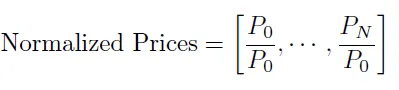

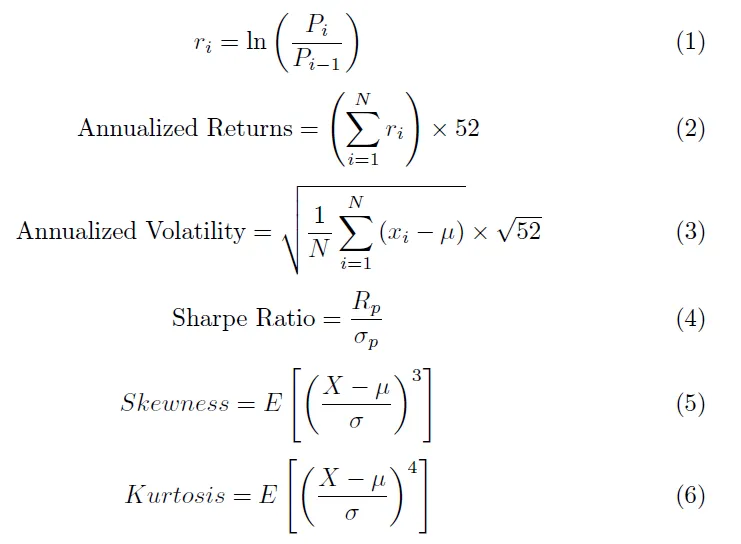

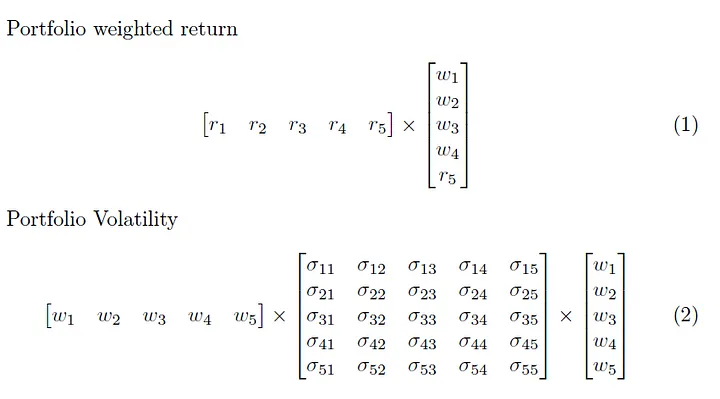

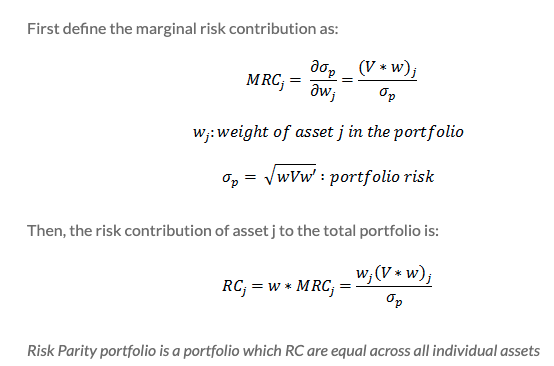

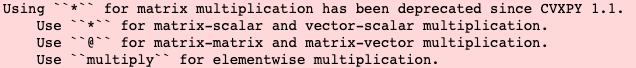

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the tickers and initial weights
tickers = ['TSLA', 'BABA', 'META', 'JPM']
w0 = [0.3, 0.2, 0.1, 0.4]  # Initial weights

# Fetch historical price data
data = yf.download(tickers, period='3y', auto_adjust=True)['Close']

# Calculate daily log returns
returns = np.log(data / data.shift(1)).dropna()

# Calculate covariance matrix (V)
V = returns.cov().values

# Calculate expected returns (R)
R = returns.mean().values

# Calculate portfolio metrics
portfolio_returns = np.dot(R, w0) * 252  # Annualized portfolio return
portfolio_volatility = np.sqrt(np.dot(w0, np.dot(V, w0))) * np.sqrt(252)  # Annualized portfolio volatility
risk_free_rate = 0.0  # Assuming no risk-free rate
sharpe_ratio = (portfolio_returns - risk_free_rate) / portfolio_volatility  # Sharpe ratio
skewness = np.dot(w0, returns.skew())  # Portfolio skewness
kurtosis = np.dot(w0, returns.kurtosis())  # Portfolio kurtosis

# Calculate maximum drawdown
cumulative_returns = np.cumsum(np.dot(returns, w0))
peak = np.maximum.accumulate(cumulative_returns)
drawdown = (cumulative_returns - peak) / peak
max_drawdown = np.min(drawdown)

#Calculate VaR
confidence_level = 0.95
var = np.percentile(np.dot(returns, w0), (1 - confidence_level) * 100) * np.sqrt(252) #worst 5% percentile, annualized

# Print the results
print("Annualized Portfolio Return:", portfolio_returns)
print("Annualized Portfolio Volatility:", portfolio_volatility)
print("Sharpe Ratio:", sharpe_ratio)
print("Skewness:", skewness)
print("Kurtosis:", kurtosis)
print("Max Drawdown:", max_drawdown)
print("VaR (95% confidence level):", var)

[*********************100%***********************]  4 of 4 completed
Annualized Portfolio Return: 0.08465531685686595
Annualized Portfolio Volatility: 0.3862951761071226
Sharpe Ratio: 0.2191467098035684
Skewness: 0.21082259939383158
Kurtosis: 7.615021998692526
Max Drawdown: -1.3377228953817197
VaR (95% confidence level): -0.6313260090783752


# Markoviz MVO

In [2]:
# mean variance, using scipy.optimize
def calculate_portfolio_var(w, V):
    # Function that calculates portfolio risk
    w = np.array(w)
    return np.dot(np.dot(w, V), w.T)

def calculate_portfolio_return(w, R):
    # Function that calculates portfolio return
    w = np.array(w)
    return np.dot(w, R)

def risk_budget_objective(x, *pars):
    # Calculate portfolio risk
    V = pars[0]  # Covariance matrix
    R = pars[1]  # Expected returns
    risk_aversion = pars[2]  # Risk aversion parameter

    # Mean-variance objective
    portfolio_return = calculate_portfolio_return(x, R)
    portfolio_var = calculate_portfolio_var(x, V)

    utility = portfolio_return - 0.5 * risk_aversion * portfolio_var

    return -utility

def total_weight_constraint(x):
    return np.sum(x) - 1.0

def long_only_constraint(x):
    return x

# Input data
w0 = [0.25, 0.25, 0.25, 0.25]  # Initial weights
risk_aversion = 3.0  # Risk aversion parameter

# Define constraints
cons = ({'type': 'eq', 'fun': total_weight_constraint},
        {'type': 'ineq', 'fun': long_only_constraint})

# Solve the optimization problem
res = minimize(risk_budget_objective, w0, args=(V, R, risk_aversion),
               method='SLSQP', constraints=cons, options={'disp': True})

# Retrieve the optimized weights
w_rb_mv = np.asmatrix(res.x)
w_rb_mv

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.00020173427393932485
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5


matrix([[5.55111512e-17, 4.23265371e-01, 2.43963653e-01, 3.32770976e-01]])

In [3]:
# mean variance using cvxpy, its a DCP problem
import cvxpy as cp

def risk_budget_objective(x, V, R, risk_aversion):
    # Calculate portfolio risk
    portfolio_return = x @ R
    portfolio_var = cp.quad_form(x, V)

    # Mean-variance objective
    utility = portfolio_return - 0.5 * risk_aversion * portfolio_var

    return utility

def total_weight_constraint(x):
    return cp.sum(x) == 1.0

def long_only_constraint(x):
    return x >= 0.0

# Input data
risk_aversion = 3.0  # Risk aversion parameter

# Define variables
x = cp.Variable(4, nonneg=True)

# Define constraints
constraints = [
    total_weight_constraint(x),
    long_only_constraint(x)
]

# Define the problem
objective = cp.Maximize(risk_budget_objective(x, V, R, risk_aversion))
problem = cp.Problem(objective, constraints)

# Solve the optimization problem
problem.solve(solver=cp.SCS)

# Retrieve the optimized weights
w_rb_mv = x.value
w_rb_mv

array([3.95294162e-10, 7.49720068e-01, 1.99944375e-09, 2.50279930e-01])

In [4]:
# Risk Parity: risk contribution of asset to the total portolio are equal
def calculate_portfolio_var(w, V):
    w = np.array(w)
    # function that calculates portfolio risk
    return np.dot(np.dot(w, V), w.T)

def calculate_risk_contribution(w, V):
    w = np.array(w)
    # function that calculates asset contribution to total risk
    sigma = np.sqrt(calculate_portfolio_var(w, V))
    # Marginal Risk Contribution
    MRC = np.dot(V, w) / sigma
    # Risk Contribution
    RC = np.multiply(MRC, w.T) 
    return RC

def risk_budget_objective(x, *pars):
    # calculate portfolio risk
    V = pars[0]  # covariance table
    x_t = pars[1]  # risk target in percent of portfolio risk
    sig_p = np.sqrt(calculate_portfolio_var(x, V))  # portfolio sigma
    
    risk_target = np.asmatrix(np.multiply(sig_p, x_t))
    asset_RC = calculate_risk_contribution(x, V)
    error = np.sum(np.square(asset_RC - risk_target.T))
    return error

def total_weight_constraint(x):
    return np.sum(x) - 1.0

def long_only_constraint(x):
    return x

w0 = [0.28, 0.42, 0.2, 0.1]  # Initial weights
x_t = [0.25, 0.25, 0.25, 0.25]  # your risk budget percent of total portfolio risk (equal risk)
cons = ({'type': 'eq', 'fun': total_weight_constraint},
         {'type': 'ineq', 'fun': long_only_constraint})

res = minimize(risk_budget_objective, w0, args=(V, x_t), method='SLSQP', constraints=cons, options={'disp': True})
w_rb = np.asmatrix(res.x)
w_rb

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.384840421563822e-08
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5


matrix([[0.19356437, 0.42735643, 0.21666438, 0.16241482]])

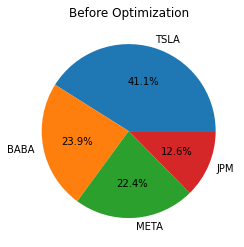

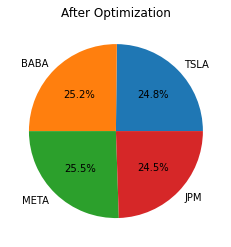

In [5]:
#Before Optimization
w1 = np.array(w0)
sigma1 = np.sqrt(np.dot(np.dot(w1, V), w1.T))
MRC1 = np.dot(V, w1)/sigma1
RC1 = np.multiply(w1,MRC1)

plt.pie(RC1, labels = tickers, autopct='%1.1f%%')
plt.title("Before Optimization")
plt.show()

#After Optimization
w2 = np.array(w_rb)[0]
sigma2 = np.sqrt(np.dot(np.dot(w2, V), w2.T))
MRC2 = np.dot(V, w2)/sigma2
RC2 = np.multiply(w2,MRC2)


plt.pie(RC2, labels = tickers,autopct='%1.1f%%')
plt.title("After Optimization")
plt.show()

The minimize function from the scipy.optimize module provides several methods for solving optimization problems. The choice of the method depends on the specific problem characteristics and requirements. Here are some commonly used methods:

Nelder-Mead (method='Nelder-Mead'): Simplex algorithm for unconstrained optimization. It is suitable for problems with a small number of parameters.

Powell (method='Powell'): Powell's method for unconstrained optimization. It explores the parameter space by iteratively fitting parabolic models.

CG (method='CG'): Conjugate Gradient algorithm for unconstrained optimization. It is suitable for large-scale problems with many parameters.

BFGS (method='BFGS'): Broyden-Fletcher-Goldfarb-Shanno algorithm for unconstrained optimization. It approximates the Hessian matrix to find the optimal solution.

L-BFGS-B (method='L-BFGS-B'): Limited-memory BFGS algorithm with bounds for constrained optimization. It is suitable for problems with simple bounds on the variables.

TNC (method='TNC'): Truncated Newton algorithm with bounds for constrained optimization. It handles both bounds on the variables and constraints.

COBYLA (method='COBYLA'): Constrained Optimization by Linear Approximations. It is suitable for problems with a small number of parameters and constraints.

SLSQP (method='SLSQP'): Sequential Least Squares Programming algorithm for constrained optimization. It handles both bounds on the variables and constraints.

The choice of the best method depends on the specific problem characteristics, such as the number of parameters, the presence of bounds or constraints, the smoothness of the objective function, and the required accuracy. There is no single best method that applies universally. It is recommended to try multiple methods and compare their performance and convergence behavior for a particular problem.

# Resample/Michaud MVO

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numpy import mean

# Define the tickers and initial weights
tickers = ['TSLA', 'BABA', 'META', 'JPM']
w0 = [0.3, 0.2, 0.1, 0.4]  # Initial weights

# Fetch historical price data
data = yf.download(tickers, period='10y', auto_adjust=True)['Close']

# Calculate daily log returns
returns = np.log(data / data.shift(1)).dropna()

# mean variance, using scipy.optimize
def calculate_portfolio_var(w, V):
    # Function that calculates portfolio risk
    w = np.array(w)
    return np.dot(np.dot(w, V), w.T)

def calculate_portfolio_return(w, R):
    # Function that calculates portfolio return
    w = np.array(w)
    return np.dot(w, R)

def risk_budget_objective(x, *pars):
    # Calculate portfolio risk
    V = pars[0]  # Covariance matrix
    R = pars[1]  # Expected returns
    risk_aversion = pars[2]  # Risk aversion parameter

    # Mean-variance objective
    portfolio_return = calculate_portfolio_return(x, R)
    portfolio_var = calculate_portfolio_var(x, V)

    utility = portfolio_return - 0.5 * risk_aversion * portfolio_var

    return -utility

def total_weight_constraint(x):
    return np.sum(x) - 1.0

def long_only_constraint(x):
    return x

# Input data
w0 = [0.25, 0.25, 0.25, 0.25]  # Initial weights
risk_aversion = 3.0  # Risk aversion parameter

# Define constraints
cons = ({'type': 'eq', 'fun': total_weight_constraint},
        {'type': 'ineq', 'fun': long_only_constraint})

num_simulations = 1000  # Choose the number of simulations as per your requirement

optimized_w = []
for i in range(num_simulations):
    # Randomly choose a start and end date for the timeseries
    start_date = returns.index[np.random.randint(len(returns)-252)]
    end_date = start_date + pd.to_timedelta('252 days')

    # Calculate the return and covariance matrix for the timeseries
    returns_subset = returns[start_date:end_date]
    R_subset = returns_subset.mean().values
    V_subset = returns_subset.cov().values

    # Solve the optimization problem
    res_subset = minimize(risk_budget_objective, w0, args=(V_subset, R_subset, risk_aversion),
                          method='SLSQP', constraints=cons, options={'disp': True})

    # Retrieve the optimized weights
    w_subset = np.asmatrix(res_subset.x)
    optimized_w.append(w_subset)

optimized_weights = mean(optimized_w, axis=0)
optimized_weights

[*********************100%***********************]  4 of 4 completed
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.002253962307829418
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0025927606095740283
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0023122138337529313
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.00250608058925468
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current functio

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0005005803344939987
            Iterations: 13
            Function evaluations: 65
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0001687289369134685
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0008768721390112102
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0007302260319832902
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.000414438821105461
            Iterations: 8
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0027111401034282437
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0016466662762065242
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0021732201865393586
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00022804704755249286
            Iterations: 14
            Function evaluations: 70
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0014168033348462424
            Iterations: 10
      

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.002548810444695593
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0016369448670051205
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0027111401034282437
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0004378145108403718
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.002396414542661985
            Iterations: 9
            Fu

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0007572643652065797
            Iterations: 12
            Function evaluations: 60
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0006175399985614594
            Iterations: 12
            Function evaluations: 60
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0012803604656420131
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.000730921351433918
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.000964263320204856
            Iterations: 6
            F

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0041667024609529126
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0044668321368782765
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.001748754338820997
            Iterations: 13
            Function evaluations: 65
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5.0897032092717045e-05
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.002304073621811095
            Iterations: 10
         

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0004922019200695093
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.000808434451747077
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0013815458140120952
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0016669311465088944
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0014991825130987117
            Iterations: 12
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.517349341737518e-05
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0031627542055551075
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.003355518836315242
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0047396431907143904
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0005443814835148655
            Iterations: 5
            

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.002727272453858277
            Iterations: 14
            Function evaluations: 70
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.001459864231884231
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.003236682526603313
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0021584186588497808
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.002071037526775959
            Iterations: 5
           

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0029506606436687853
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.00294267786684586
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0013956344141457604
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0021639516379153385
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.110382891385039e-05
            Iterations: 11
            F

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00014245560578706633
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0010051955388618353
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.000644610184520355
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0007544639483721547
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.006978085520100274
            Iterations: 11
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0014035911094653756
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0021639516379153385
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.003732959845535174
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0021248340121157593
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.005693146405729588
            Iterations: 11
            F

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.00043378476935765787
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0007359347905990569
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0007331637664586071
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0008558905877491997
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.002571318707775211
            Iterations: 9
            

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.002914232404766114
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0010380482253020745
            Iterations: 13
            Function evaluations: 65
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0013602737153650683
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0004606676973698371
            Iterations: 14
            Function evaluations: 70
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.000276350579248578
            Iterations: 10
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0009147973914814343
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.00023826590231524556
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0009115126659826328
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0006984609895341143
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.005737033464559891
            Iterations: 10
       

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0031977863145664703
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0002819408794339865
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.000734311676048368
            Iterations: 13
            Function evaluations: 65
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.002914232404766114
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.001222382499576729
            Iterations: 5
            F

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0006380540961852708
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.00016543397691646622
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0008978059763334115
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.001899691472970683
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.00023826590231524556
            Iterations: 10
        

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.002063594612673107
            Iterations: 14
            Function evaluations: 70
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.002016876128337723
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0015977330961931438
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0005177796007394761
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0008761719058936574
            Iterations: 13
           

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0012358065641842216
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0007966116680936132
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0010852045654735159
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0007028902981456718
            Iterations: 12
            Function evaluations: 60
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0020098553536379233
            Iterations: 10
        

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.00031372320514843873
            Iterations: 14
            Function evaluations: 70
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.002701674011824426
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.002318697168581996
            Iterations: 14
            Function evaluations: 70
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0009617912047673483
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0004249855672808711
            Iterations: 6
            

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0004462087438250129
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00026212978020713956
            Iterations: 15
            Function evaluations: 75
            Gradient evaluations: 15
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0024412177261728535
            Iterations: 11
            Function evaluations: 55
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0018427218691979656
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.003033824062712205
            Iterations: 9
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0008901979476311232
            Iterations: 12
            Function evaluations: 60
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0006538702488689802
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0007606844075014215
            Iterations: 13
            Function evaluations: 65
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.004452273287543522
            Iterations: 13
            Function evaluations: 65
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.001976271726687154
            Iterations: 14
        

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0005526367392327035
            Iterations: 12
            Function evaluations: 60
            Gradient evaluations: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0006354739280524168
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0027171602260853277
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.00017449485967275938
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0012819345409974174
            Iterations: 16
       

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0006402390440296876
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.003524358821839605
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0007171054494712976
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0012205616919398925
            Iterations: 13
            Function evaluations: 65
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0045644149037067875
            Iterations: 13
       

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0005667620814123426
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0005851842010071797
            Iterations: 14
            Function evaluations: 70
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0007135079893847827
            Iterations: 5
            Function evaluations: 25
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0032710484291419047
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0027602700679417486
            Iterations: 14
         

array([[0.16217974, 0.37020418, 0.18789429, 0.2797218 ]])